In [1]:
import numpy as np
# from IPython.display import Image, display

import sys
sys.path.append('../') # Add the course directory to the Python path
import cphy.plotting as cplot

import matplotlib.pyplot as plt
%matplotlib inline




# Monte Carlo and Metropolis Sampling

The total energy of an $N$ particle system with pairwise interactions is given by

$$
E = \dfrac12 \sum_{i=1}^N \sum_{j \neq i}^N V_{ij}
$$
where the interaction energy $V_{ij}$ includes interactions like $V(\mathbf{r}_i - \mathbf{r}_j)$ that depend only on the separation between particles $i$ and $j$.

In traditional Metropolis sampling, we propose a new configuration of the system by moving a single particle by a random amount. We compute the energy change between the original and proposed configurations,

$$
\Delta E = E_\text{new} - E_\text{old}
$$

If $\Delta E < 0$, we accept the new configuration. If $\Delta E > 0$, we accept the new configuration with probability $\exp(-\beta \Delta E)$, where $\beta = 1/k_B T$ is the inverse temperature of the sampling process. In a machine learning context, we would identify $\beta$ as a hyperparameter that controls properties of the optimization.

### Why the probabilistic acceptance rule?

You might think that the fastest convergence would occur if we always accepted updates that lower the energy, and always rejected updates that increase the energy (equivalent to $\beta=0$). The probabilistic update rule here represents a way for the optimizer to avoid getting stuck in local minima.



In [2]:

class MetropolisMonteCarlo:
    """
    Metropolis algorithm for optimizing a loss function.
    """
    def __init__(
            self, 
            loss, 
            beta=1.0, 
            amplitude=1.0, 
            max_iter=500,
            random_state=None, 
            store_history=False
        ):
        self.energy = loss
        self.beta = beta
        self.amplitude = amplitude
        self.n_iter = max_iter
        self.store_history = store_history
        self.random_state = random_state

    def perturb(self, X):
        """
        Randomly the state of the system.
        
        Args:
            X (ndarray): The current state of the system

        Returns:
            Xp (ndarray): The perturbed state of the system
        """
        Xp = X + self.amplitude * np.random.normal(size=X.shape)
        return Xp

    def update(self, X):
        """
        Update the state of the system.
        
        Args:
            X (ndarray): The current state of the system

        Returns:
            X (ndarray): The updated state of the system
        """
        rho = np.random.random()
        Xp = self.perturb(X)
        e_delta = self.energy(Xp) - self.energy(X)
        if e_delta < 0:
            return Xp
        if rho < np.exp(-self.beta * e_delta):
            return Xp
        else:
            return X

    def fit(self, X):
        """
        Run the Monte Carlo simulation.
        
        Args:
            X (ndarray): The initial state of the system

        Returns:
            X (ndarray): The final state of the system
        """
        np.random.seed(self.random_state)
        if self.store_history:
            self.history = [X]
        for _ in range(self.n_iter):
            X = self.update(X)
            if self.store_history:
                self.history.append(X)
        return X

In [3]:
from cphy.losses import RandomGaussianLandscape

# Instantiate a random loss
loss = RandomGaussianLandscape(random_state=0, n_wells=8)

# Initialize optimizer
optimizer = MetropolisMonteCarlo(loss, beta=1e2, amplitude=0.1, random_state=0, store_history=True)

# Initialize starting point
np.random.seed(0)
X0 = np.random.normal(loc=(0, 0.5), size=(1, 2))

# Fit optimizer
Xopt = optimizer.fit(X0.copy()).squeeze()

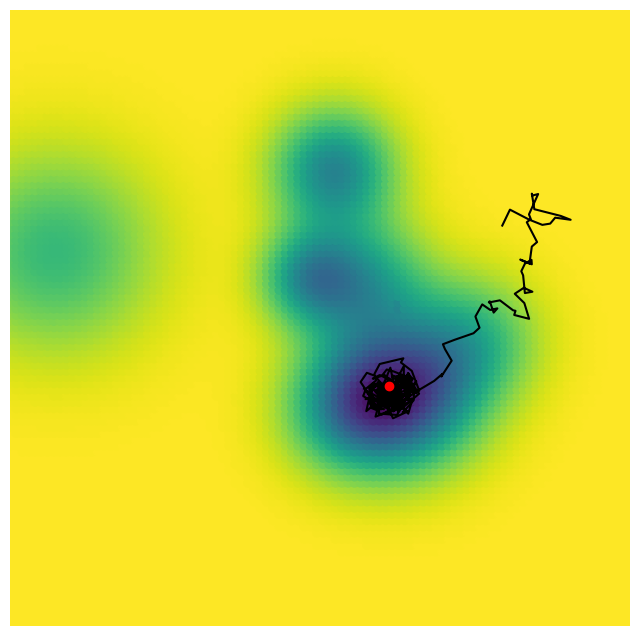

In [7]:
history = np.array(optimizer.history).squeeze()

loss.plot()
plt.plot(history[:, 0], history[:, 1], 'k')
plt.plot(Xopt[0], Xopt[1], 'o', color='red')
# plt.xlim(np.min(Xopt[0]), np.max(Xopt[0]))
# plt.ylim(-2, 2)

cplot.vanish_axes()

## Hard sphere packing with the Metropolis algorithm

A basic problem in materials science, statistical physics, and the theory of disordered systems is to find the densest possible packing of hard spheres in a finite volume. 


We define a hard sphere as a sphere of radius $R$ that cannot overlap with any other sphere. The packing fraction $\phi$ is the fraction of the volume that is occupied by the spheres.

The interaction potential between two spheres is given by

$$
V(r) = \begin{cases}
\infty & r < 2R \\
0 & r > 2R
\end{cases}
$$

where $r$ is the distance between the centers of the spheres. Note that, because we have an infinite potential, the Metropolis update step simplifies dramatically. Recall that, in traditional Metropolis, we calculate the ratio of the Boltzmann factors for the current and proposed configurations:

$$
\frac{e^{-\beta E_{\text{new}}}}{e^{-\beta E_{\text{old}}}} = e^{-\beta (E_{\text{new}} - E_{\text{old}})}
$$

In our case, the energy difference is either zero or infinity, so the ratio is either 1 or 0. This means that the acceptance probability is either 1 or 0, and we can simply accept or reject the proposed move based on whether the proposal causes an overlap between two spheres

### References

+ *Random Heterogeneous Materials: Microstructure and Macroscopic Properties*, by Sal Torquato




In [2]:
from scipy.spatial.distance import pdist
import itertools

class HardSpherePacking:
    """
    Simulate hard sphere packing using Metropolis algorithm. The simulation in
    specified by the number of spheres, and the desired volume fraction set initially. 
    The radius of the spheres is calculated to achieve the target volume fraction. 

    Args:
        n (int): number of particles
        phi (float): packing fraction
        zeta (float): maximum displacement

    Attributes:
        coords (np.ndarray): coordinates of sphere centers
        overlap (float): minimum distance between sphere centers
    """

    def __init__(self, n, phi, zeta=0.005, store_history=False):
        self.N = n
        self.phi = phi 
        self.zeta = zeta
        self.coords = self.initialize_lattice()
        self.radius = (6 * phi/(np.pi * n))**(1/3)
        self.store_history = store_history

        self.acceptance_rate = None
        if store_history:
            self.history = list()

    def initialize_lattice(self):
        """
        Generate a cubic initial conditions mesh within the unit cube

        Returns:
            np.ndarray: coordinates of particles in a three-dimensional mesh
        """
        nx = ny = nz = int(np.ceil(self.N**(1/3)))
        x = np.linspace(0, 1, nx + 1)[:-1]
        y = np.linspace(0, 1, ny + 1)[:-1]
        z = np.linspace(0, 1, nz + 1)[:-1]
        xx, yy, zz = np.meshgrid(x, y, z)
        coords = np.vstack((xx.flatten(), yy.flatten(), zz.flatten())).T

        #coords = np.random.choice(coords, size=self.N, replace=False)
        return coords[:self.N]

    def augment_lattice(self, coords):
        """
        Given a set of coordinates, build an augmented lattice of coordinates by 
        shifting each coordinate by 1 in each direction.

        Args:
            coords (np.ndarray): coordinates of the particles

        Returns:
            np.ndarray: augmented coordinates
        """
        coords_augmented = list()
        # there are 27 possible shifts to fully surround a simulation box with 
        # replicates to create boundary conditions
        for shift in itertools.product([-1., 0., 1.], repeat=3):
            coords_augmented.append(coords.copy() + np.array(shift))
        return np.vstack(coords_augmented).copy()

    def is_overlap(self, coords, index):
        """
        Given a set of coordinates, check whether the sphere at the specified index 
        overlaps with any other sphere.

        Args:
            coords (np.ndarray): coordinates of the particles
            index (int): index of the particle to check

        Returns:
            bool: whether the particle overlaps with any other particle
        """
        # apply periodic boundary conditions
        coos = self.augment_lattice(coords) 

        # compute distances between all particles and indexed particle
        dists = np.sqrt(np.sum((coords[index] - coos)**2, axis=1))

        dists = dists[dists > 0] # remove self-overlap term
        return np.any(dists < self.radius)

    def fit(self, num_iter=1000, verbose=False):
        """
        Run the Metropolis algorithm for the specified number of iterations. Can be 
        restarted to continue the simulation.

        Args:
            num_iter (int): number of iterations
            verbose (bool): whether to print progress

        Returns:
            self
        """
        accepts, rejects = 0, 0
        if self.store_history:
            self.history.append(self.coords.copy())
        for i in range(num_iter):

            
            for j in range(self.N):
                newcoords = self.coords.copy()
                x0 = self.coords[j]
                pert = self.zeta * (2 * np.random.rand(3) - 1)
                xp = x0 + pert

                ## Boundary conditions
                xp = xp - np.floor(xp + 0.5)

                newcoords[j] = xp
                if not self.is_overlap(newcoords, j):
                    self.coords[j] = xp
                    accepts += 1
                else:
                    rejects += 1

            ## Report progress and update history      
            if verbose:
                if i % 50 == 0: print(f"Step {i}", flush=True)
            if self.store_history:
                self.history.append(self.coords.copy())

        self.acceptance_rate = accepts / (accepts + rejects)
        return self


In [ ]:
## Run simulation

hsp = HardSpherePacking(1000, 0.45, store_history=True)

hsp.fit(num_iter=5000, verbose=True)
## Save the history because this simulation is demanding
# np.savez('../private_resources/monte_carlo_metropolis.npz', np.array(hsp.history))

print(f"Terminated Metropolis with acceptance rate {hsp.acceptance_rate}")

## The pairwise correlation function

The pairwise correlation function is defined as the probability of finding a particle at a distance $r$ from another particle, given that the other particle is at the origin. It is given by

$$
g_2(r) = \frac{1}{\rho N} \langle \sum_{i=1}^N \sum_{j \neq i} \delta(r - |\mathbf{r}_i - \mathbf{r}_j|) \rangle
$$

where $\rho$ is the overall number density of particles. The sum over $j$ excludes the $i=j$ term, which would be infinite. The delta function ensures that the sum is only over pairs of particles that are separated by a distance $r$. The factor of $1/N$ ensures that the sum is normalized by the number of particles, while the factor of $1/\rho$ ensures that the sum is normalized by the volume of the system.

For finite-size systems, $g_2(r)$ as defined here appears "spiky," comprising a series corresponding to all possible pairs of particles. In the thermodynamic limit, however, the spikes become infinitely narrow and the function becomes smooth. In order to estimate $g_2(r)$ for a finite-size system, we must smooth the function by binning it. We will use a bin size of $\Delta r$. In this case, the correlation function is given by

$$
g_2(r) = \frac{1}{\rho N} \langle \sum_{i=1}^N \sum_{j \neq i} \frac{1}{\Delta r} \Theta(r - |\mathbf{r}_i - \mathbf{r}_j|) \rangle
$$

where $\Theta$ is the Heaviside step function. The factor of $1/\Delta r$ ensures that the sum is normalized by the bin size.


In [ ]:
from scipy.spatial.distance import pdist

def compute_g2(coords, nbins=180, rmax=0.5):
    """
    Given a set of coordinates, compute the pair correlation function g2(r)

    Args:
        coords (np.ndarray): coordinates of the particles
        nbins (int): number of bins to use for the histogram
        rmax (float): maximum distance to consider for the histogram

    Returns:
        bins (np.ndarray): bin edges
        g2 (np.ndarray): pair correlation function
    """
    D = pdist(coords) # computes pairwise distances among all particles
    bins = np.linspace(0, rmax, nbins)
    hist, bins = np.histogram(D, bins=bins)
    ## divide by the volume of the shell
    g2 = hist / (len(coords) * 4*np.pi/3 * (bins[1:]**3 - bins[:-1]**3))
    return bins, g2

(-0.5, 0.5)

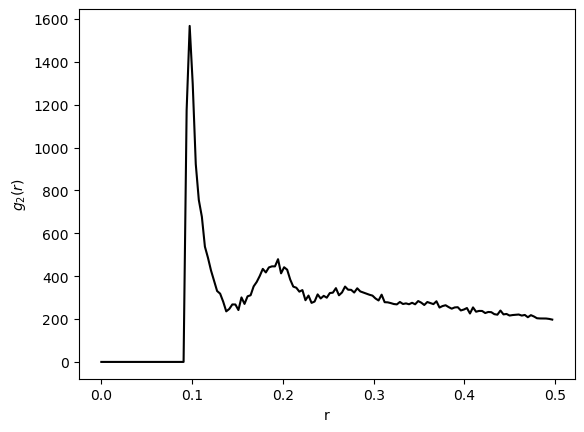

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

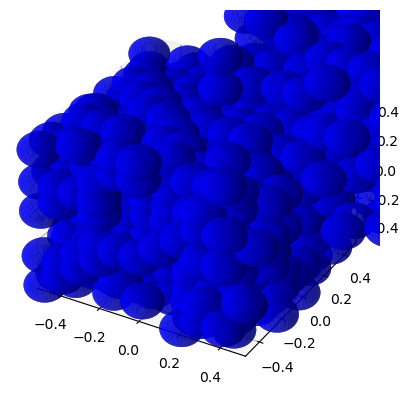

<Figure size 640x480 with 0 Axes>

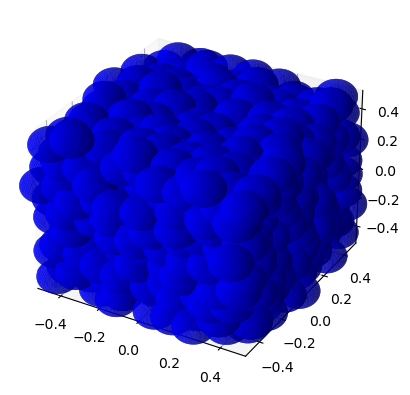

In [33]:
from cphy.plotting import plt_sphere

## Load the history
# hsp.history = np.load('../private_resources/monte_carlo_metropolis.npz', allow_pickle=True)['arr_0']
# hsp.coords = hsp.history[-1]

bins, hist = compute_g2(hsp.coords, nbins=150)
plt.figure()
plt.plot(bins[:-1], hist, 'k')
plt.xlabel(r'r')
plt.ylabel(r'$g_2(r)$')

plt.figure()
fig = plt.figure()
plt_sphere(hsp.history[1].copy(), hsp.radius)
plt.xlim([-0.5, 0.5])
plt.ylim([-0.5, 0.5])
plt.gca().set_zlim([-0.5, 0.5])

fig = plt.figure()
plt_sphere(hsp.history[-1].copy(), hsp.radius),
plt.xlim([-0.5, 0.5])
plt.ylim([-0.5, 0.5])
plt.gca().set_zlim([-0.5, 0.5]) 


In [24]:
## Make an interactive video
from ipywidgets import interact
import ipywidgets as widgets


def plotter(i):
    coords = hsp.history[i]
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c='b', marker='o', s=100, alpha=0.2)
    ax.set_zlim(-0.5, 0.5)
    plt.xlim([-0.5, 0.5])
    plt.ylim([-0.5, 0.5])
    
    plt.show()

interact(
    plotter, 
    i=widgets.IntSlider(min=5, max=len(hsp.history)-1, step=1, value=0)
)



interactive(children=(IntSlider(value=5, description='i', max=1643, min=5), Output()), _dom_classes=('widget-i…

<function __main__.plotter(i)>

## Questions

+ We have a double loop: an outer loop over all iterations, and an inner loop where we go over each individual particle, jostle it, and check for overlaps. Why can't this inner loop be vectorized?

+ How would we generalize this approach to a soft-repulsive potential?


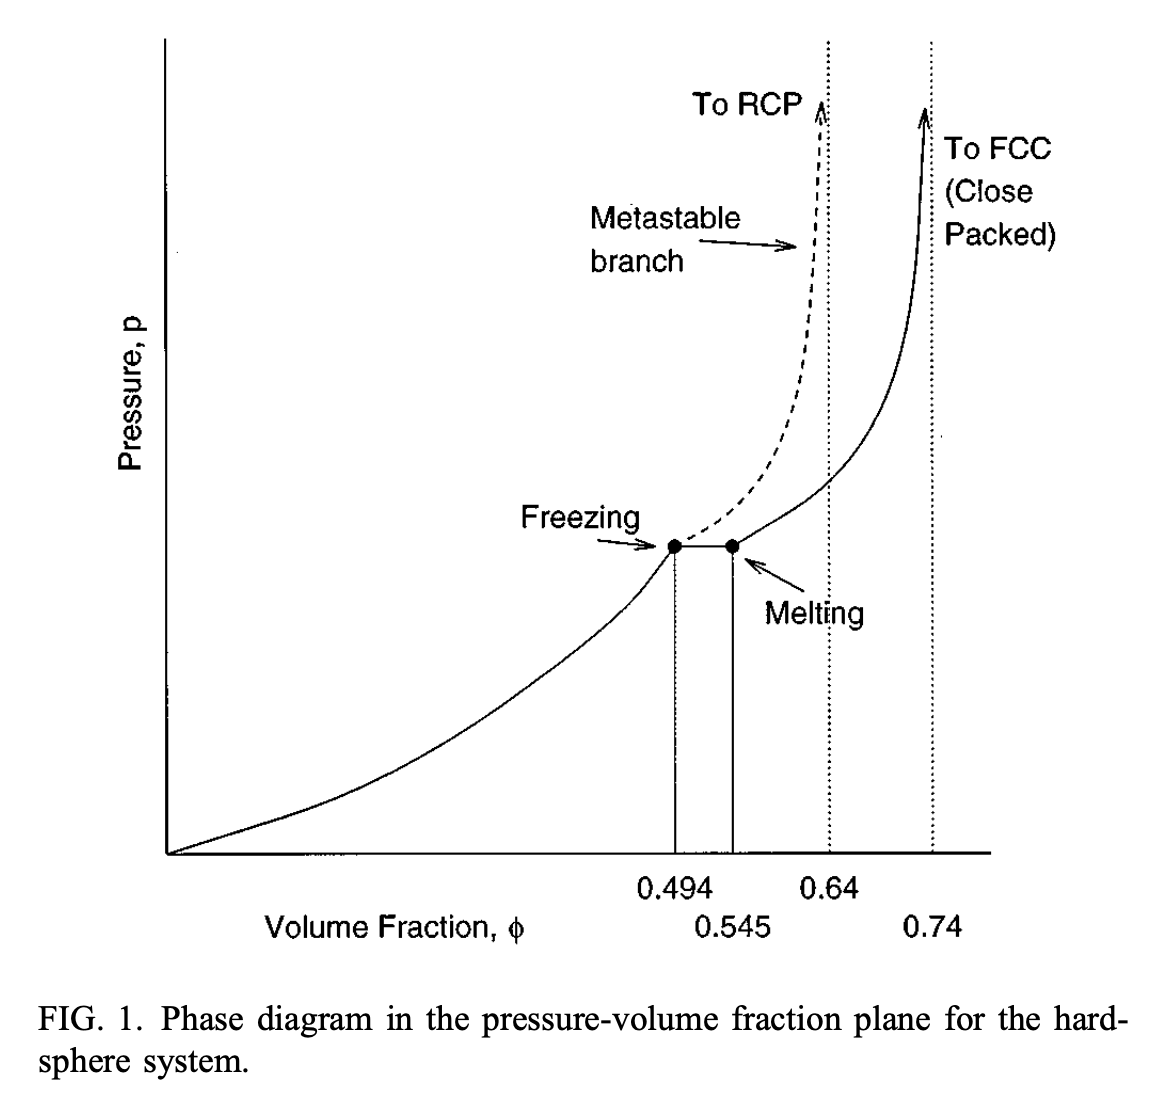

In [40]:
from IPython.display import Image
Image("../resources/hardsphere_diagram.png", width=500)
# Computer simulations of dense hard‐sphere systems, Rintoul & Torquato. JCP 1996

A recent [modification of the Metropolis algorithm by Muller et al.](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.13.031006), rearranges the acceptance step

$$
\Delta E = -\dfrac{\log \rho}{\beta} \equiv \Delta E_{th}
$$

where $\rho$ is a random number between 0 and 1. We therefore re-frame the Metropolis update as determining whether the proposed energy change $\Delta E$ lies above or below the random threshold $\Delta E_{th}$.

The key insight of Müller et al. is that $\Delta E$ does not need to be known exactly. Rather, it is sufficient to establish a set of upper and lower bounds, $\Delta E \in [\Delta E_{min}, \Delta E_{max}]$. If $\Delta E_{min} < \Delta E_{th}$ then the update is accepted. If $\Delta E_{max} < \Delta E_{th}$ then the update is rejected probabilistically.